



## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad, het_arch
from scipy.stats import shapiro
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Dataset

In [ ]:
df = pd.read_csv("Data Forecast Emas - Copy.csv")
df

,Waktu,Inflasi,Policy_Rate,Suku_Bunga,Kurs_USD,Minyak_Dunia,Harga_Emas
0,1/1/2018 0:00,0.0325,0.0425,0.0100,13387,866540.51,569763
1,1/2/2018 0:00,0.0318,0.0425,0.0107,13740,846933.60,579873
2,1/3/2018 0:00,0.0340,0.0425,0.0085,13760,893574.40,583934
3,1/4/2018 0:00,0.0341,0.0425,0.0084,13910,953808.70,594163
4,1/5/2018 0:00,0.0323,0.0450,0.0127,13890,931185.60,589993
...,...,...,...,...,...,...,...
87,1/4/2025 0:00,0.0195,0.0575,0.0380,16600,966286.00,1745782
88,1/5/2025 0:00,0.0160,0.0550,0.0390,16290,990269.10,1731187
89,1/6/2025 0:00,0.0187,0.0550,0.0363,16235,1057060.85,1722603
90,1/7/2025 0:00,0.0237,0.0525,0.0288,16455,1139673.30,1738511


## EDA

--- Informasi Awal Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Waktu         92 non-null     object 
 1   Inflasi       92 non-null     float64
 2   Policy_Rate   92 non-null     float64
 3   Suku_Bunga    92 non-null     float64
 4   Kurs_USD      92 non-null     int64  
 5   Minyak_Dunia  92 non-null     float64
 6   Harga_Emas    92 non-null     int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.2+ KB

--- Statistik Deskriptif ---
         Inflasi  Policy_Rate  Suku_Bunga      Kurs_USD  Minyak_Dunia  \
count  92.000000    92.000000   92.000000     92.000000  9.200000e+01   
mean    0.027760     0.049620    0.022582  14903.043478  1.013174e+06   
std     0.010894     0.009924    0.012648    833.319799  2.724107e+05   
min    -0.000900     0.035000    0.000100  13387.000000  2.799624e+05   
25%     0.020575     0.

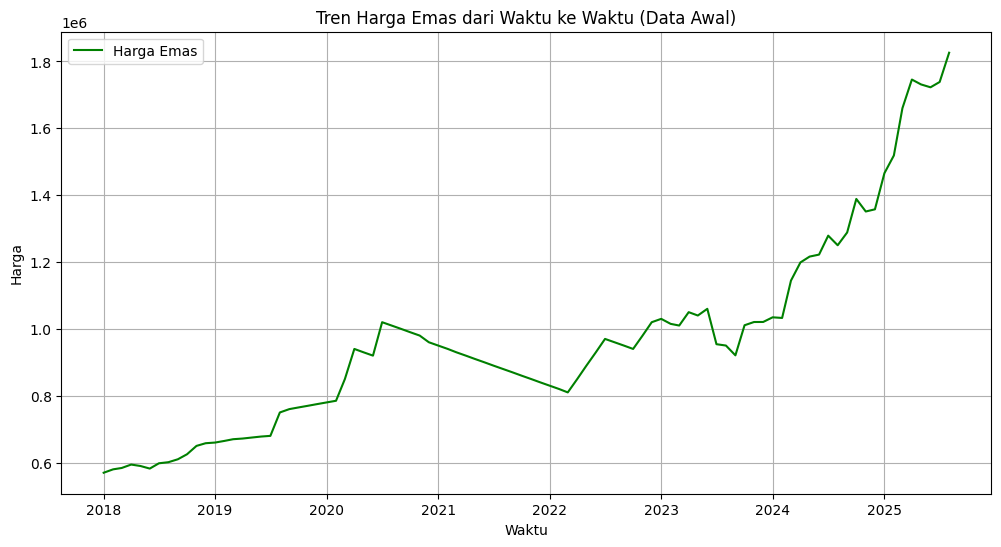


--- Matriks Korelasi (Tabel) ---
               Inflasi  Policy_Rate  Suku_Bunga  Kurs_USD  Minyak_Dunia  \
Inflasi       1.000000     0.114543   -0.667862 -0.130726      0.319509   
Policy_Rate   0.114543     1.000000    0.623219  0.499334      0.095101   
Suku_Bunga   -0.667862     0.623219    1.000000  0.507664     -0.116117   
Kurs_USD     -0.130726     0.499334    0.507664  1.000000      0.394231   
Minyak_Dunia  0.319509     0.095101   -0.116117  0.394231      1.000000   
Harga_Emas   -0.358081     0.266230    0.515594  0.819351      0.259083   

              Harga_Emas  
Inflasi        -0.358081  
Policy_Rate     0.266230  
Suku_Bunga      0.515594  
Kurs_USD        0.819351  
Minyak_Dunia    0.259083  
Harga_Emas      1.000000  


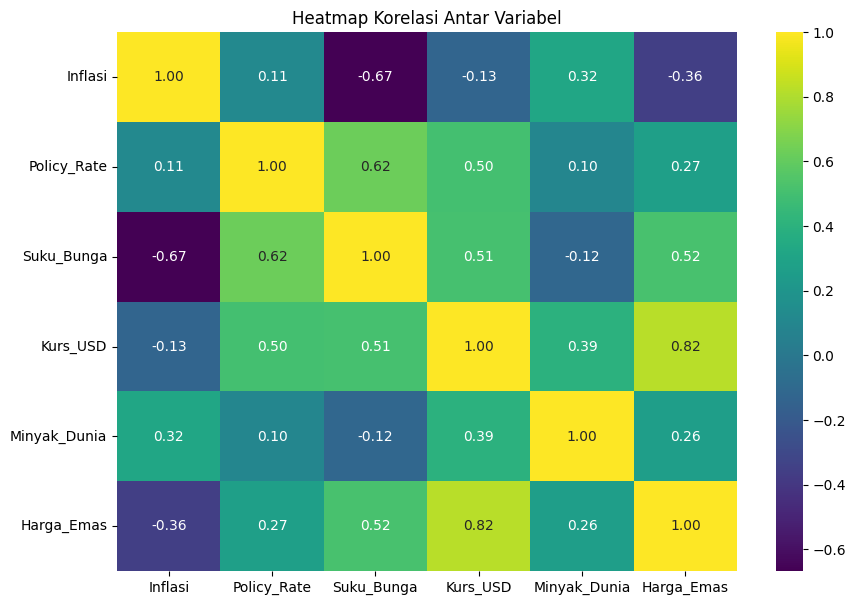

In [ ]:
# --- 1. Inspeksi Awal ---
print("--- Informasi Awal Dataset ---")
df.info()

print("\n--- Statistik Deskriptif ---")
print(df.describe())

# --- 2. Visualisasi Tren Harga Emas ---
# Konversi 'Waktu' menjadi tipe datetime untuk plotting
df['Waktu'] = pd.to_datetime(df['Waktu'], format='%d/%m/%Y %H:%M')
df = df.sort_values('Waktu').set_index('Waktu')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Harga_Emas'], label="Harga Emas", color='green')
plt.title("Tren Harga Emas dari Waktu ke Waktu (Data Awal)")
plt.xlabel("Waktu")
plt.ylabel("Harga")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Analisis Korelasi ---
# Menghitung dan mencetak matriks korelasi
correlation_matrix = df.select_dtypes(include='number').corr()
print("\n--- Matriks Korelasi (Tabel) ---")
print(correlation_matrix)

# Memvisualisasikan matriks korelasi sebagai heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

## Preprocessing

In [ ]:
# 1. Pilih kolom numerik yang digunakan
cols_used = ['Inflasi', 'Policy_Rate', 'Suku_Bunga', 'Kurs_USD', 'Minyak_Dunia', 'Harga_Emas']

# 2. Cek missing value
print("Jumlah missing per kolom:")
print(df[cols_used].isna().sum())

# 3. Salin dataframe baru untuk variabel yang dipakai
data = df[cols_used].copy()

# 4. Terapkan log untuk variabel berskala besar
log_cols = ['Kurs_USD', 'Minyak_Dunia', 'Harga_Emas']
for c in log_cols:
    data[c] = np.log(data[c])

# 5. Preview hasil akhir
print("\nDataset setelah preprocessing:")
print(data.head())


Jumlah missing per kolom:
Inflasi         0
Policy_Rate     0
Suku_Bunga      0
Kurs_USD        0
Minyak_Dunia    0
Harga_Emas      0
dtype: int64

Dataset setelah preprocessing:
            Inflasi  Policy_Rate  Suku_Bunga  Kurs_USD  Minyak_Dunia  \
Waktu                                                                  
2018-01-01   0.0325       0.0425      0.0100  9.502039     13.672264   
2018-02-01   0.0318       0.0425      0.0107  9.528067     13.649378   
2018-03-01   0.0340       0.0425      0.0085  9.529521     13.702985   
2018-04-01   0.0341       0.0425      0.0084  9.540363     13.768218   
2018-05-01   0.0323       0.0450      0.0127  9.538924     13.744214   

            Harga_Emas  
Waktu                   
2018-01-01   13.252976  
2018-02-01   13.270564  
2018-03-01   13.277543  
2018-04-01   13.294909  
2018-05-01   13.287866  


## Uji Stasioneritas

In [ ]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"{name:<12} | p-value={result[1]:.5f} | stat={result[0]:.4f}")

print("=== UJI STASIONERITAS (LEVEL) ===")
for c in cols_used:
    adf_test(data[c], c)

print("\n=== UJI STASIONERITAS (FIRST DIFFERENCE) ===")
for c in cols_used:
    adf_test(data[c].diff(), c + '_diff')

=== UJI STASIONERITAS (LEVEL) ===
Inflasi      | p-value=0.16250 | stat=-2.3299
Policy_Rate  | p-value=0.19094 | stat=-2.2432
Suku_Bunga   | p-value=0.33279 | stat=-1.8985
Kurs_USD     | p-value=0.18551 | stat=-2.2591
Minyak_Dunia | p-value=0.26365 | stat=-2.0534
Harga_Emas   | p-value=0.98871 | stat=0.6467

=== UJI STASIONERITAS (FIRST DIFFERENCE) ===
Inflasi_diff | p-value=0.00164 | stat=-3.9599
Policy_Rate_diff | p-value=0.00006 | stat=-4.7831
Suku_Bunga_diff | p-value=0.00000 | stat=-7.2392
Kurs_USD_diff | p-value=0.00000 | stat=-7.3206
Minyak_Dunia_diff | p-value=0.00000 | stat=-6.3392
Harga_Emas_diff | p-value=0.00000 | stat=-8.0960


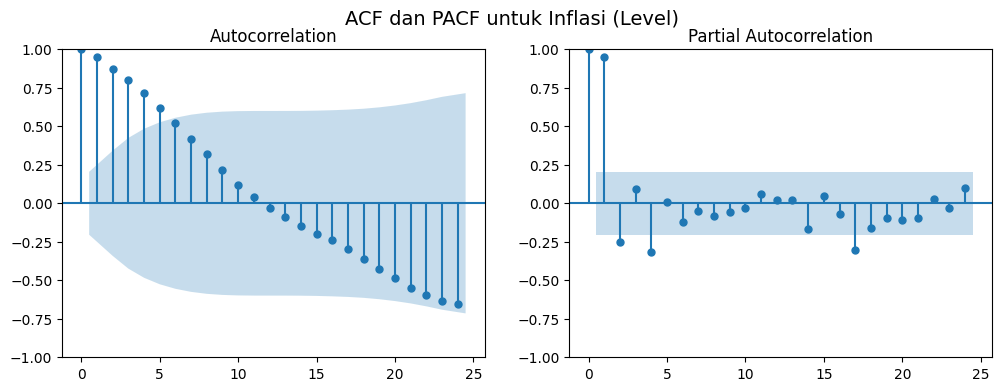

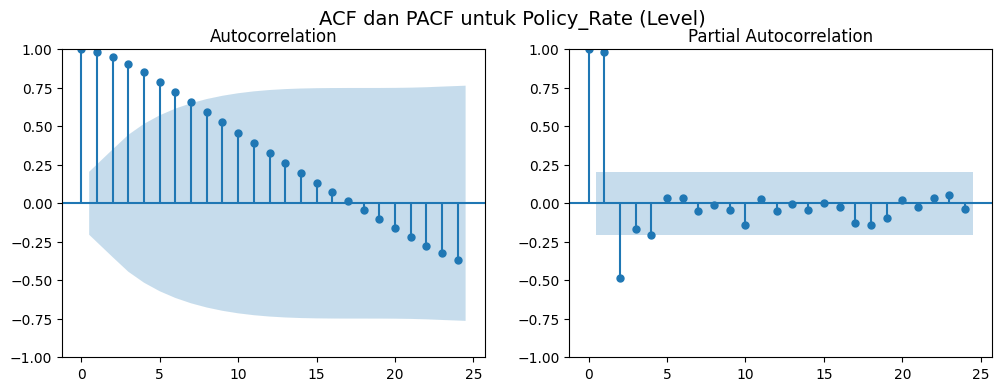

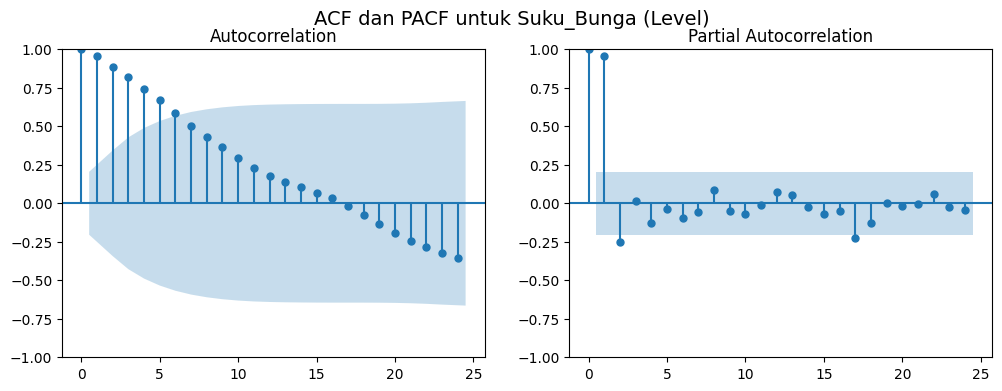

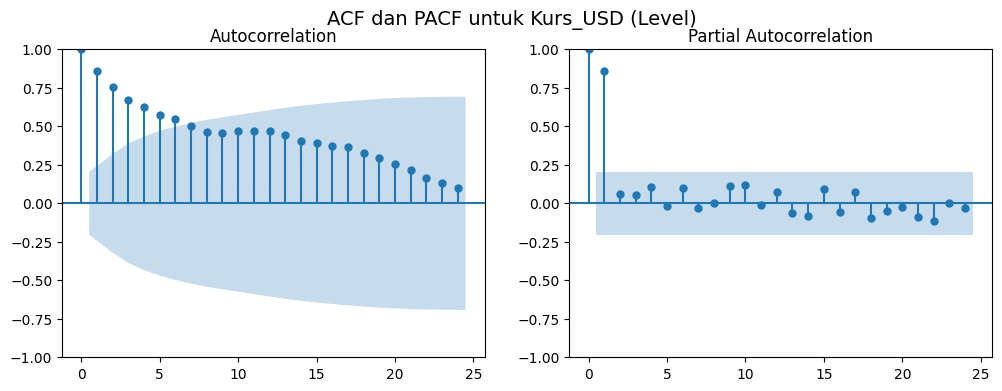

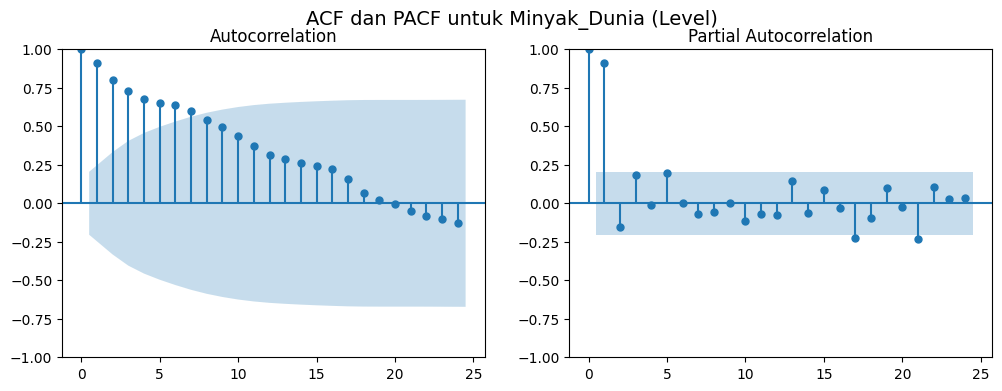

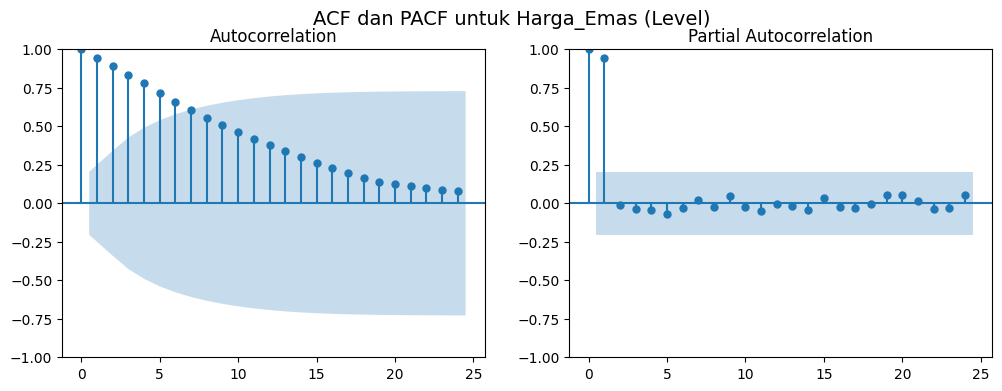

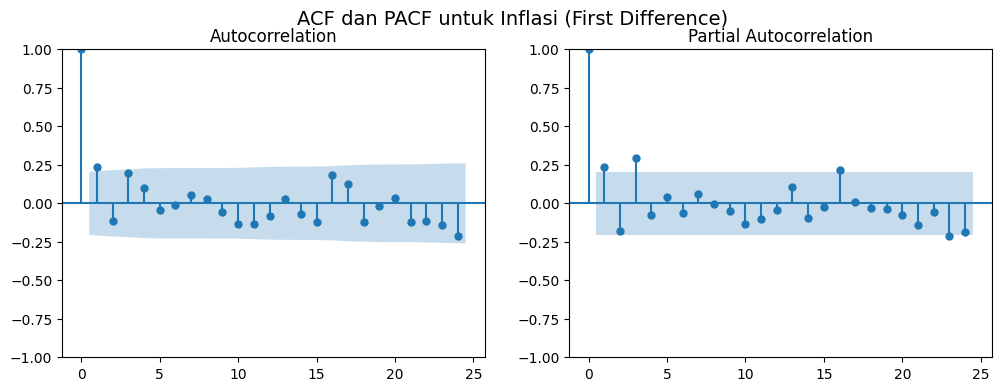

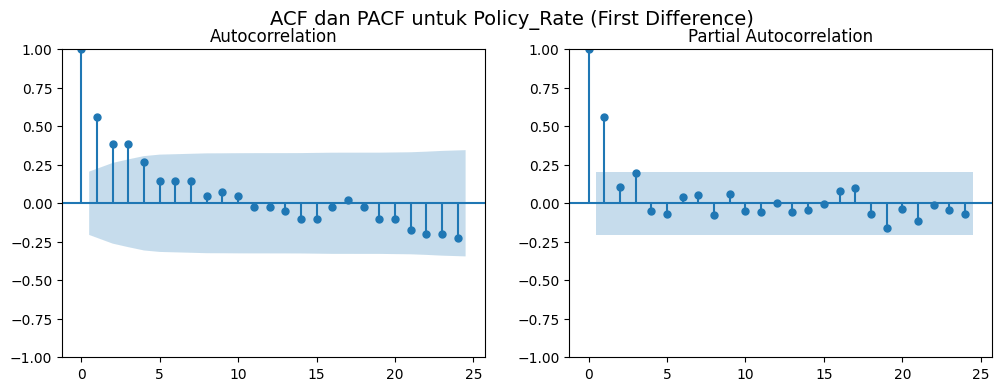

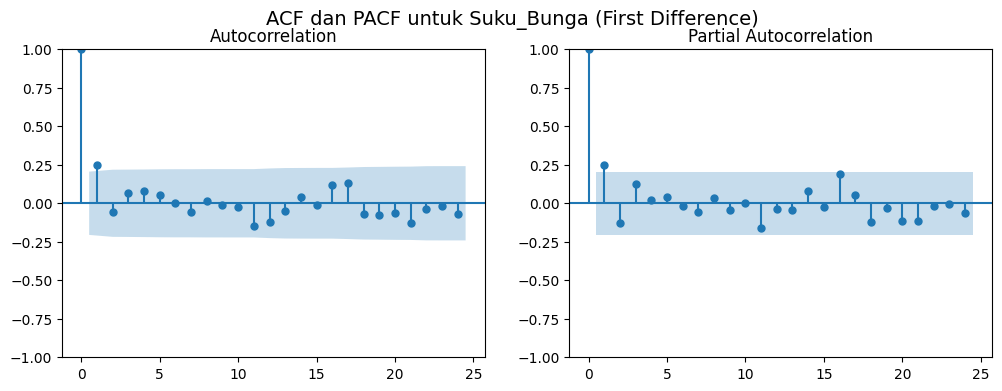

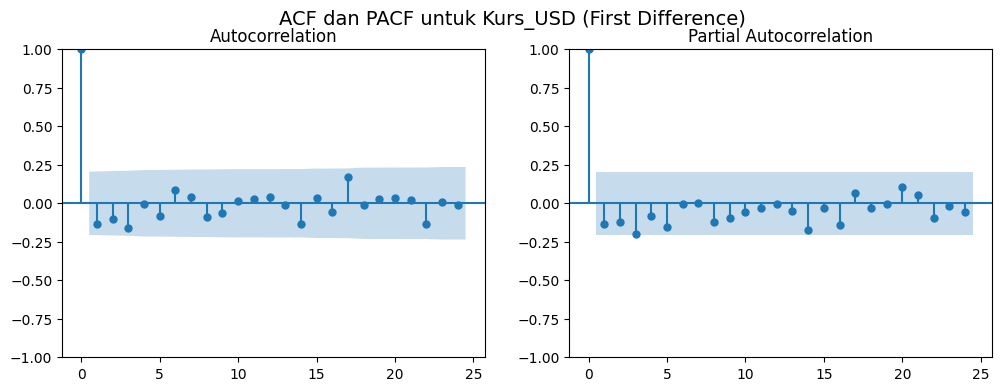

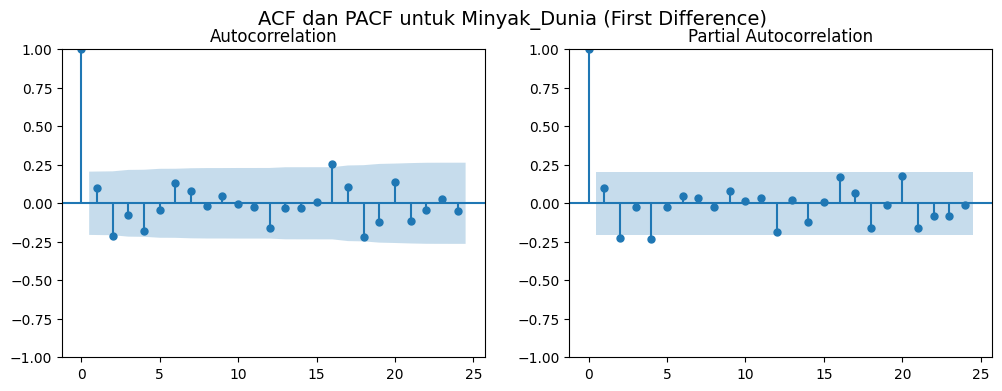

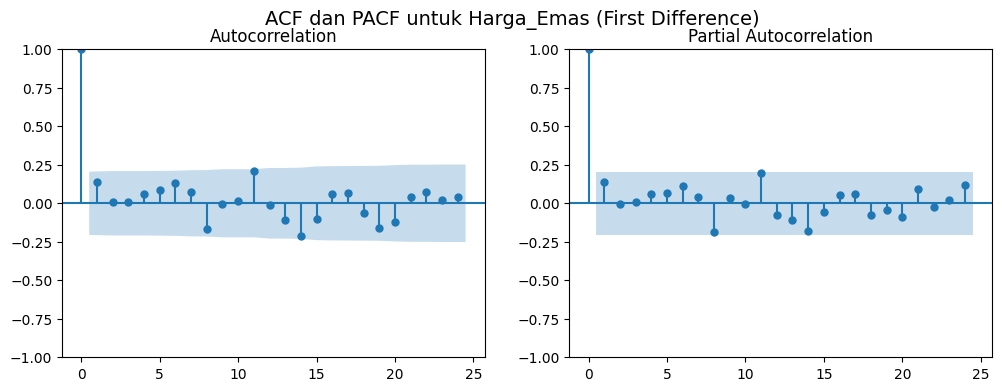

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Plot ACF dan PACF per variabel ===
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (12, 4)})

for c in cols_used:
    fig, axes = plt.subplots(1, 2)
    plot_acf(data[c].dropna(), lags=24, ax=axes[0])
    plot_pacf(data[c].dropna(), lags=24, ax=axes[1])
    fig.suptitle(f"ACF dan PACF untuk {c} (Level)", fontsize=14)
    plt.show()

# === Plot ACF dan PACF untuk First Difference ===
for c in cols_used:
    fig, axes = plt.subplots(1, 2)
    plot_acf(data[c].diff().dropna(), lags=24, ax=axes[0])
    plot_pacf(data[c].diff().dropna(), lags=24, ax=axes[1])
    fig.suptitle(f"ACF dan PACF untuk {c} (First Difference)", fontsize=14)
    plt.show()


## Uji Kointegrasi

In [ ]:
jres = coint_johansen(data, det_order=0, k_ar_diff=1)
print("\n=== HASIL UJI KOINTEGRASI JOHANSEN ===")
print("Trace stat :", jres.lr1)
print("Critical 95%:", jres.cvt[:,1])


=== HASIL UJI KOINTEGRASI JOHANSEN ===
Trace stat : [1.62235473e+02 9.29589120e+01 5.18248461e+01 2.48426853e+01
 8.60120959e+00 9.15155572e-03]
Critical 95%: [95.7542 69.8189 47.8545 29.7961 15.4943  3.8415]


In [ ]:
coint_rank = 3
print("Rank kointegrasi =", coint_rank)

Rank kointegrasi = 3


## Penentuan Lag Optimal

In [ ]:
model_var = VAR(data)
sel = model_var.select_order(maxlags=6)
print("\n=== PENENTUAN LAG OPTIMAL ===")
print(sel.summary())
lag_optimal = sel.selected_orders['aic'] or 2
k_ar_diff = max(1, lag_optimal - 1)
print(f"Digunakan k_ar_diff = {k_ar_diff}")


=== PENENTUAN LAG OPTIMAL ===
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -42.33      -42.16   4.123e-19      -42.26
1      -55.26     -54.06*   1.003e-24      -54.78
2     -55.86*      -53.63  5.596e-25*     -54.96*
3      -55.80      -52.55   6.101e-25      -54.49
4      -55.61      -51.33   7.828e-25      -53.89
5      -55.34      -50.03   1.136e-24      -53.20
6      -55.15      -48.81   1.603e-24      -52.60
-------------------------------------------------
Digunakan k_ar_diff = 1


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Splitting Data

In [ ]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]
print(f"\nTrain: {train.index[0].date()} - {train.index[-1].date()}")
print(f"Test : {test.index[0].date()} - {test.index[-1].date()}")


Train: 2018-01-01 - 2024-01-01
Test : 2024-02-01 - 2025-08-01


## Fitting Model

In [ ]:
vecm_model = VECM(data, k_ar_diff=k_ar_diff, coint_rank=coint_rank, deterministic='co')
vecm_res = vecm_model.fit()
print("\n=== HASIL FITTING MODEL VECM ===")
print(vecm_res.summary())


=== HASIL FITTING MODEL VECM ===
Det. terms outside the coint. relation & lagged endog. parameters for equation Inflasi
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0712      0.130      0.547      0.585      -0.184       0.327
L1.Inflasi          0.0693      0.172      0.402      0.688      -0.269       0.407
L1.Policy_Rate      0.3608      0.285      1.268      0.205      -0.197       0.919
L1.Suku_Bunga      -0.1061      0.164     -0.645      0.519      -0.428       0.216
L1.Kurs_USD         0.0116      0.017      0.667      0.505      -0.022       0.046
L1.Minyak_Dunia     0.0013      0.003      0.450      0.652      -0.004       0.007
L1.Harga_Emas       0.0053      0.011      0.475      0.635      -0.017       0.027
Det. terms outside the coint. relation & lagged endog. parameters for equation Policy_Rate
                      coef    st

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## Uji Diagnostik

In [ ]:
resid = vecm_res.resid  # numpy array shape (n_obs - k_ar_diff, n_vars)
cols = cols_used

# Ljung-Box (several lags)
print("\nLjung-Box (lags 1,6,12,24):")
for i, col in enumerate(cols):
    print(f"\n-- Residual: {col} --")
    for lag in [1,6,12,24]:
        lb = acorr_ljungbox(resid[:, i], lags=[lag], return_df=True)
        print(f"lag={lag} p={lb['lb_pvalue'].iloc[0]:.4f}")

# Normality tests
print("\nNormality AD + Shapiro:")
for i, col in enumerate(cols):
    ad_stat, ad_p = normal_ad(resid[:, i])
    sh_stat, sh_p = shapiro(resid[:, i])
    print(f"{col}: AD p={ad_p:.4f}, Shapiro p={sh_p:.4f}")

# ARCH tests
print("\nARCH test (nlags=12):")
for i, col in enumerate(cols):
    try:
        arch_res = het_arch(resid[:, i], nlags=12)
        print(f"{col}: ARCH lm p={arch_res[1]:.4f}, f p={arch_res[3]:.4f}")
    except Exception as e:
        print(f"{col}: ARCH error: {e}")

# ADF on residuals
print("\nADF on residuals (stationarity):")
from statsmodels.tsa.stattools import adfuller
for i, col in enumerate(cols):
    r = adfuller(resid[:, i])
    print(f"{col}: ADF p-value={r[1]:.6f}")


Ljung-Box (lags 1,6,12,24):

-- Residual: Inflasi --
lag=1 p=0.8465
lag=6 p=0.0824
lag=12 p=0.2348
lag=24 p=0.0786

-- Residual: Policy_Rate --
lag=1 p=0.5028
lag=6 p=0.6585
lag=12 p=0.7954
lag=24 p=0.7804

-- Residual: Suku_Bunga --
lag=1 p=0.8100
lag=6 p=0.7949
lag=12 p=0.9471
lag=24 p=0.9454

-- Residual: Kurs_USD --
lag=1 p=0.6468
lag=6 p=0.7981
lag=12 p=0.9747
lag=24 p=0.9942

-- Residual: Minyak_Dunia --
lag=1 p=0.2882
lag=6 p=0.2575
lag=12 p=0.3272
lag=24 p=0.3414

-- Residual: Harga_Emas --
lag=1 p=0.7678
lag=6 p=0.1570
lag=12 p=0.0139
lag=24 p=0.0025

Normality AD + Shapiro:
Inflasi: AD p=0.0033, Shapiro p=0.0011
Policy_Rate: AD p=0.2789, Shapiro p=0.7023
Suku_Bunga: AD p=0.0843, Shapiro p=0.0080
Kurs_USD: AD p=0.0001, Shapiro p=0.0000
Minyak_Dunia: AD p=0.0001, Shapiro p=0.0000
Harga_Emas: AD p=0.0000, Shapiro p=0.0000

ARCH test (nlags=12):
Inflasi: ARCH lm p=0.2666, f p=0.2745
Policy_Rate: ARCH lm p=0.2029, f p=0.2030
Suku_Bunga: ARCH lm p=0.5301, f p=0.5631
Kurs_USD: ARCH

## Cek Stabilitas Model

=== CEK STABILITAS MODEL VECM ===
Nilai eigenvalues (akar karakteristik):
[0.46512451+0.00000000e+00j 0.55611138+0.00000000e+00j
 1.        +0.00000000e+00j 0.91326356+0.00000000e+00j
 1.        +1.00074151e-16j 1.        -1.00074151e-16j]


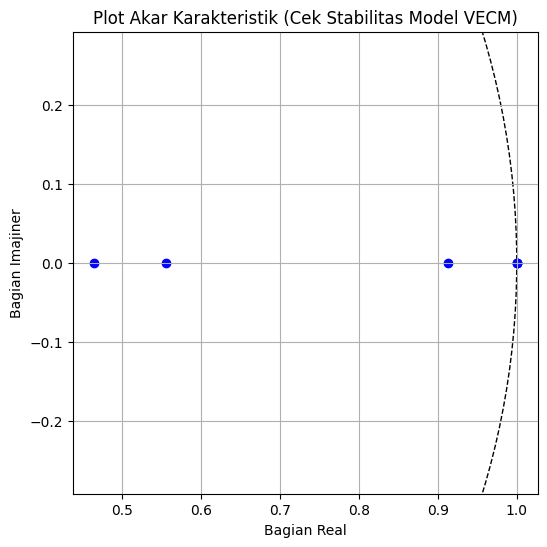

In [ ]:
eig_vals = np.linalg.eigvals(vecm_res.alpha @ vecm_res.beta.T + np.eye(vecm_res.alpha.shape[0]))
print("=== CEK STABILITAS MODEL VECM ===")
print("Nilai eigenvalues (akar karakteristik):")
print(eig_vals)

# Visualisasi stabilitas
plt.figure(figsize=(6,6))
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)
plt.scatter(eig_vals.real, eig_vals.imag, color='blue')
plt.title("Plot Akar Karakteristik (Cek Stabilitas Model VECM)")
plt.xlabel("Bagian Real")
plt.ylabel("Bagian Imajiner")
plt.grid(True)
plt.axis('equal')
plt.show()

## Uji FEVD

FEVD for Inflasi
       Inflasi  Policy_Rate  Suku_Bunga  Kurs_USD  Minyak_Dunia  Harga_Emas
0     1.000000     0.000000    0.000000  0.000000      0.000000    0.000000
1     0.985808     0.003621    0.000979  0.000003      0.009546    0.000045
2     0.954660     0.007125    0.002646  0.000996      0.034533    0.000040
3     0.913044     0.008743    0.002643  0.002957      0.072450    0.000165
4     0.864671     0.009111    0.002529  0.004976      0.118215    0.000499
5     0.813672     0.008735    0.003309  0.007000      0.166463    0.000821
6     0.764824     0.008057    0.003749  0.009256      0.212998    0.001116
7     0.720768     0.007684    0.003537  0.011964      0.254570    0.001477
8     0.682262     0.008214    0.003561  0.015264      0.288735    0.001965
9     0.649509     0.010041    0.004370  0.019181      0.314337    0.002561
10    0.622464     0.013342    0.005778  0.023637      0.331604    0.003176
11    0.600636     0.018159    0.007407  0.028499      0.341591    0.00

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Figure size 1000x600 with 0 Axes>

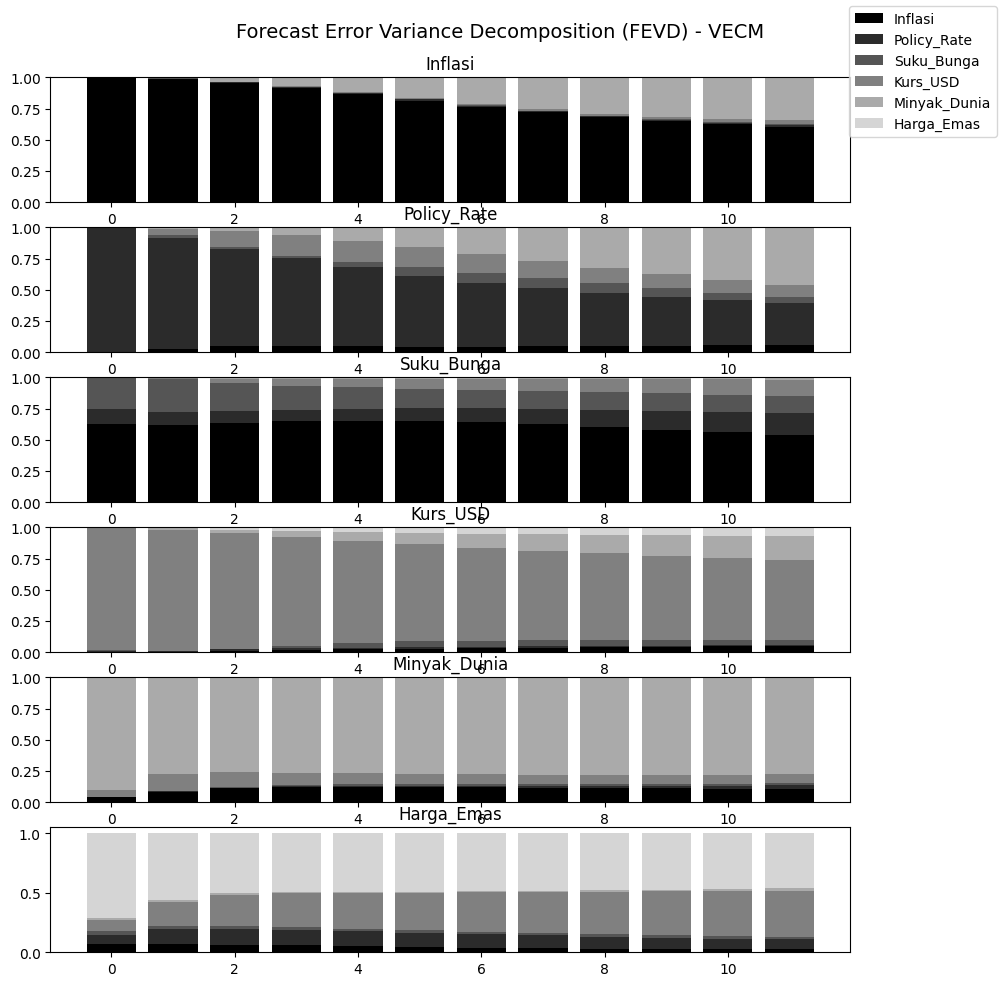

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# === Ambil parameter dari model VECM ===
k_ar_diff = vecm_res.k_ar
k_ar = k_ar_diff + 1

# Ambil koefisien short-run (Γ), matriks penyesuaian (α), dan kointegrasi (β)
Gamma = vecm_res.gamma        # short-run coefficients (ΔY_{t-i})
Alpha = vecm_res.alpha        # adjustment speed
Beta = vecm_res.beta          # cointegration matrix

# === Konversi ke representasi VAR tereduksi ===
n = Gamma.shape[1]  # jumlah variabel
Pi = Alpha @ Beta.T
Phi = np.eye(n) + Pi

# === Bentuk koefisien VAR dari hasil VECM ===
var_coefs = np.zeros((k_ar, n, n))
var_coefs[0] = Phi
for i in range(1, k_ar):
    var_coefs[i] = -Gamma[i-1]

# Bangun ulang model VAR dari data yang sama
var_model = VAR(data)
var_res = var_model.fit(maxlags=k_ar_diff)

# === Forecast Error Variance Decomposition (FEVD) ===
fevd = var_res.fevd(12)
print(fevd.summary())

plt.figure(figsize=(10,6))
fevd.plot()
plt.suptitle("Forecast Error Variance Decomposition (FEVD) - VECM", fontsize=14)
plt.show()

## IRF

=== Impulse Response Function (IRF) ===


<Figure size 1800x1200 with 0 Axes>

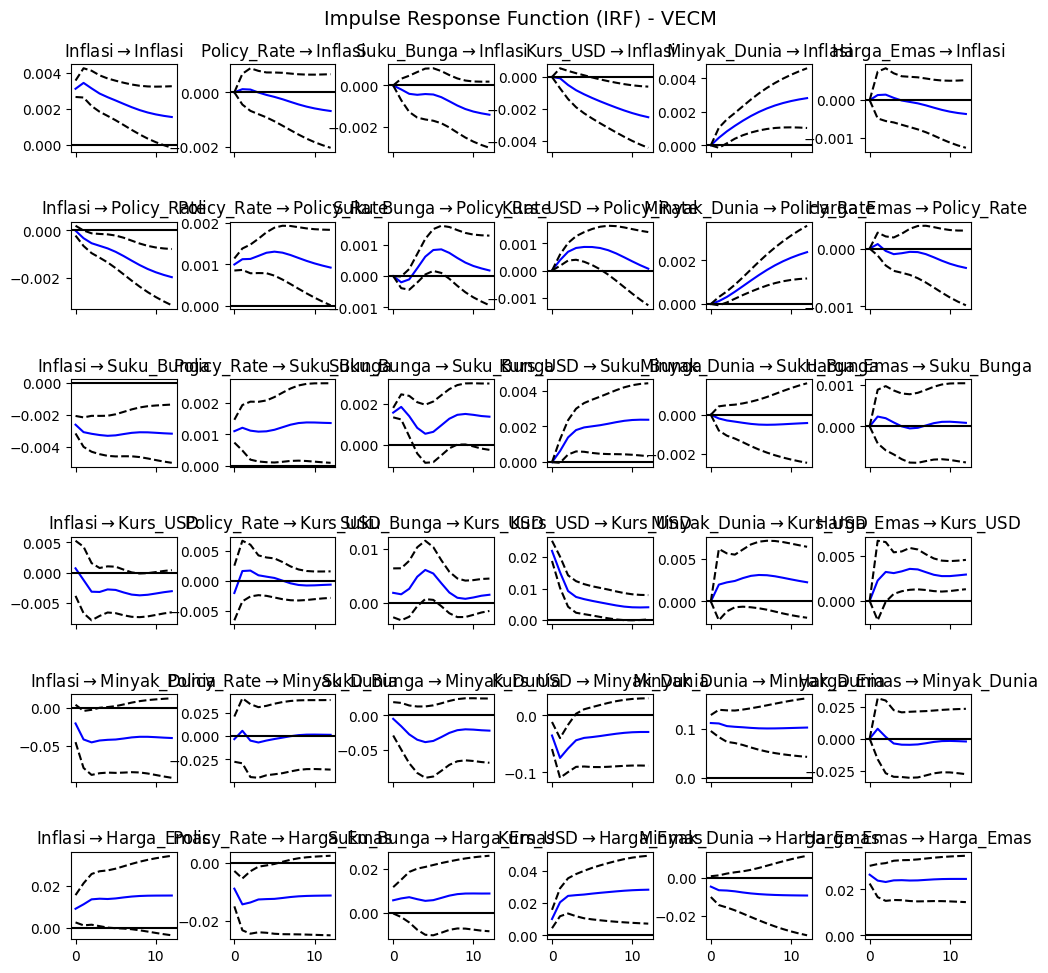

In [ ]:
irf = vecm_res.irf(12)
print("=== Impulse Response Function (IRF) ===")
plt.figure(figsize=(18, 12))
irf.plot(orth=True)
plt.suptitle("Impulse Response Function (IRF) - VECM", fontsize=14)
plt.subplots_adjust(wspace=0.5, hspace=0.8)
plt.show()

## Evaluasi


=== Evaluasi Model (In-sample, pakai fittedvalues) ===
MAE  : 24,192.89
RMSE : 35,510.41
MAPE : 2.30%


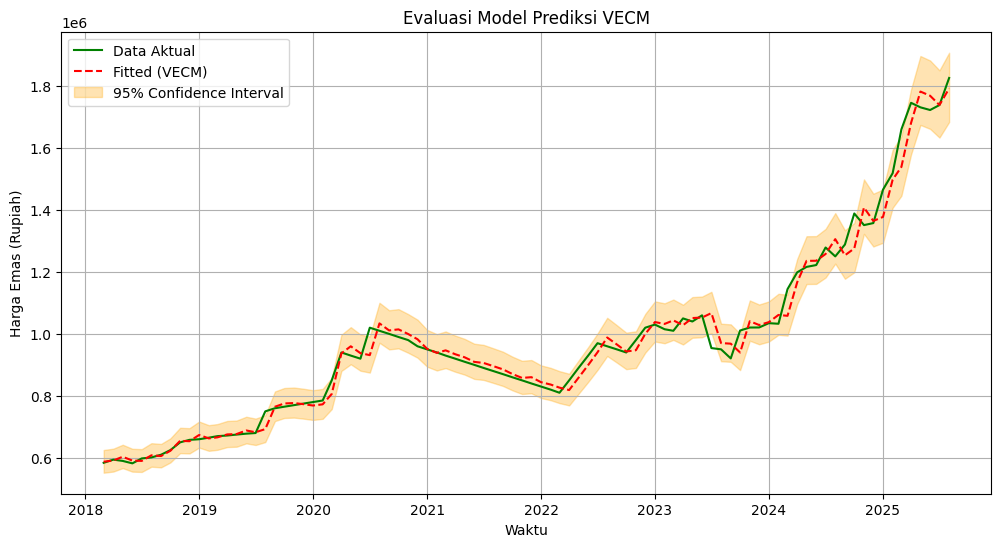

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Evaluasi In-sample dengan fittedvalues ===
def inverse_transform_df(df_log_values, log_cols):
    """Inverse transform results: apply exp only to columns in log_cols."""
    df_inv = df_log_values.copy()
    for c in df_inv.columns:
        if c in log_cols:
            df_inv[c] = np.exp(df_inv[c])
        else:
            df_inv[c] = df_inv[c]
    return df_inv

# Ambil fitted log dari model
fitted_log = vecm_res.fittedvalues  # aligned from t = k_ar_diff onward
fitted_log_df = pd.DataFrame(fitted_log, index=data.dropna().index[k_ar_diff:], columns=data.columns)
fitted_df = inverse_transform_df(fitted_log_df, log_cols)

# Data aktual (sudah inverse transform)
actual_df = inverse_transform_df(
    pd.DataFrame(data.dropna().values, index=data.dropna().index, columns=data.columns),
    log_cols
)
# Align indeks
actual = actual_df.iloc[k_ar_diff:]['Harga_Emas']
pred = fitted_df['Harga_Emas']

# === Hitung metrik error ===
mae = mean_absolute_error(actual, pred)
rmse = np.sqrt(mean_squared_error(actual, pred))
mape = np.mean(np.abs((actual - pred) / actual)) * 100

print("\n=== Evaluasi Model (In-sample, pakai fittedvalues) ===")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"MAPE : {mape:.2f}%")

# === Hitung interval kepercayaan ===
resid_emas = vecm_res.resid[:, data.columns.get_loc('Harga_Emas')]
resid_std = np.std(resid_emas)
z = norm.ppf(0.975)  # 95%

forecast_upper = pred * np.exp(z * resid_std)
forecast_lower = pred * np.exp(-z * resid_std)

# === Plot ===
plt.figure(figsize=(12,6))
plt.plot(actual.index, actual, label='Data Aktual', color='green')
plt.plot(pred.index, pred, label='Fitted (VECM)', color='red', linestyle='--')
plt.fill_between(pred.index, forecast_lower, forecast_upper,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("Evaluasi Model Prediksi VECM")
plt.xlabel("Waktu")
plt.ylabel("Harga Emas (Rupiah)")
plt.legend()
plt.grid(True)
plt.show()

## Forecasting (12 Bulan Selanjutnya)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


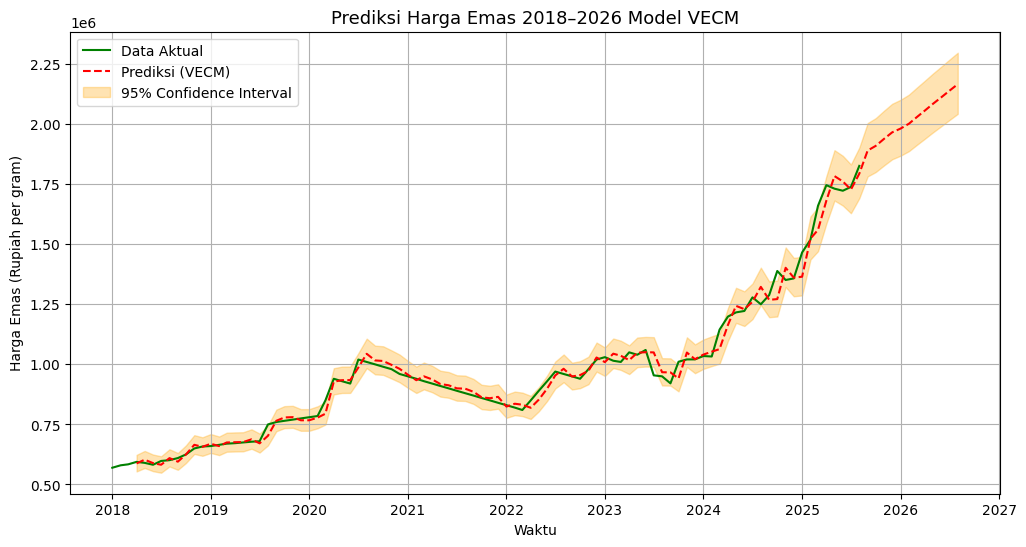

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import VECM

# --- Refit model full sample ---
vecm_full = VECM(data, k_ar_diff=k_ar_diff, coint_rank=coint_rank, deterministic='co')
vecm_res_full = vecm_full.fit()

# --- Ambil fitted (in-sample) ---
fitted_log = vecm_res_full.fittedvalues
fitted_df = pd.DataFrame(fitted_log, index=data.index[-len(fitted_log):], columns=cols_used)
fitted_df = np.exp(fitted_df)  # balik ke skala normal

# --- Forecast out-of-sample (12 bulan ke depan) ---
n_future = 12
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                               periods=n_future, freq='MS')

forecast_future_log = vecm_res_full.predict(steps=n_future)
forecast_future = np.exp(pd.DataFrame(forecast_future_log, index=forecast_index, columns=cols_used))

# --- Gabungkan fitted + forecast jadi satu prediksi penuh ---
full_forecast = pd.concat([fitted_df, forecast_future])

# --- Hitung interval kepercayaan ---
resid_emas = vecm_res_full.resid[:, cols_used.index('Harga_Emas')]
resid_std = np.std(resid_emas)
z = norm.ppf(0.975)

forecast_mean = full_forecast['Harga_Emas']
forecast_upper = forecast_mean * np.exp(z * resid_std)
forecast_lower = forecast_mean * np.exp(-z * resid_std)

# --- Plot: Data aktual + prediksi penuh + interval ---
plt.figure(figsize=(12,6))
plt.plot(np.exp(data['Harga_Emas']), label='Data Aktual', color='green')
plt.plot(full_forecast.index, forecast_mean, label='Prediksi (VECM)', color='red', linestyle='--')
plt.fill_between(full_forecast.index, forecast_lower, forecast_upper,
                 color='orange', alpha=0.3, label='95% Confidence Interval')

plt.title("Prediksi Harga Emas 2018–2026 Model VECM", fontsize=13)
plt.xlabel("Waktu")
plt.ylabel("Harga Emas (Rupiah per gram)")
plt.legend()
plt.grid(True)
plt.show()
